# Processing scripts for generating figures for Dafne paper

## Processing log file

In [1]:
import os
from typing import Iterable
import re

DELETE_NONANON_FILES = False

def find_elements_pattern(string_list: Iterable[str], pattern: str):
    return [ s for s in string_list if re.match(pattern, s) is not None]

### Anonymization

In [2]:
user_map = {}
current_user = 1

def get_anonymized_user(user_str):
    global user_map, current_user
    try:
        return user_map[user_str]
    except KeyError:
        user_map[user_str] = f'{current_user:07d}'
        current_user += 1
        return user_map[user_str]

def anonymize_line(line: str):
    pattern = 'accessed by (\S+)'
    rep = lambda m: f'accessed by {get_anonymized_user(m.group(1))}'
    line = re.sub(pattern, rep, line)
    pattern2 = 'Log message from (\S+)'
    rep2 = lambda m: f'Log message from {get_anonymized_user(m.group(1))}'
    line = re.sub(pattern2, rep2, line)
    pattern3 = r'([0-9]+)_(\S+).model'
    rep3 = lambda m: f'{m.group(1)}_{get_anonymized_user(m.group(2))}.model'
    line = re.sub(pattern3, rep3, line)
    return line
    

def anonymize_file(filename: str):
    global user_map, current_user
    user_map = {}
    current_user = 1
    out_filename = filename[:-3] + 'anon.txt'
    with open(filename, 'r') as input_file:
        with open(out_filename, 'w') as output_file:
            for line in input_file:
                output_file.write(anonymize_line(line))

files = os.listdir()
nonanon_log_files = find_elements_pattern(files, 'log.*(?<!anon)\.txt')
for file in nonanon_log_files:
    anonymize_file(file)
    if DELETE_NONANON_FILES:
        os.unlink(file)
    print('Anonymized', file)


Anonymized log_20220831_orig.txt
Anonymized log_20230102_orig.txt


### Read in anonymized file

In [3]:
import os
from dateutil.parser import parse
import pandas as pd

files = os.listdir()
anon_log_files = find_elements_pattern(files, 'log.*anon\.txt')
anon_log_file = anon_log_files[0]
print('Reading from', anon_log_file)

def split_log_line(line: str):
    date_part = line[:27]
    text_part = line[27:].strip()
    date = parse(date_part)
    return (date, text_part)

with open(anon_log_file,'r') as f:
    log_lines = [ split_log_line(line) for line in f ]
    
log_frame = pd.DataFrame(log_lines, columns = ['DateTime', 'Message'])
log_frame = log_frame.set_index('DateTime')


Reading from log_20230102_orig.anon.txt


### Filter dates and messages

In [4]:
from datetime import datetime

date_start = datetime(2021,7,1)

sub_frame = log_frame.loc[date_start:]

In [5]:
# Extract dice scores

def extract_dice(line):
    m = re.search('client dice ([0-9.]+)', line)
    if not m: return None
    return float(m.group(1))

dice_messages_mask = sub_frame['Message'].str.contains('client dice')
dice_messages_frame = sub_frame[dice_messages_mask]
dice_scores = dice_messages_frame['Message'].apply(extract_dice)

def extract_user(line):
    m = re.search('upload_model accessed by ([0-9]+)', line)
    if not m: return None
    return int(m.group(1))

users = dice_messages_frame['Message'].apply(extract_user)

def extract_model(line):
    m = re.search('upload_model accessed by [0-9]+ - ([a-zA-Z]+) -', line)
    if not m: return None
    return m.group(1)

model_type = dice_messages_frame['Message'].apply(extract_model)

users_and_dice = pd.DataFrame({'User': users, 'Model': model_type, 'Dice': dice_scores})
print(users_and_dice)

                            User  Model      Dice
DateTime                                         
2021-07-05 07:46:53.006620    14    Leg       NaN
2021-07-05 08:43:32.036859     6    Leg  0.722032
2021-07-05 12:34:23.546306     9    Leg       NaN
2021-07-05 13:39:20.021036     9    Leg       NaN
2021-07-06 00:03:03.163500     7    Leg  0.061336
...                          ...    ...       ...
2022-12-14 12:53:54.709914     5  Thigh  0.586073
2022-12-20 14:59:34.579354     5  Thigh       NaN
2022-12-21 11:19:24.642261     5  Thigh       NaN
2022-12-21 15:33:15.415373     5  Thigh       NaN
2022-12-22 12:11:15.017470     5  Thigh       NaN

[806 rows x 3 columns]


In [6]:
users_and_dice_notNan = users_and_dice[users_and_dice['Dice'] >= 0]
print(users_and_dice_notNan)
users_and_dice_filt = users_and_dice[users_and_dice['Dice'] > 0.1]
users_and_dice_filt = users_and_dice_filt[users_and_dice_filt['Dice'] < 0.99]
users_and_dice_filt.insert(0, 'date_rank', range(len(users_and_dice_filt)))
users_and_dice_filt.set_index('date_rank', inplace=True)
print(users_and_dice_filt)

                            User  Model      Dice
DateTime                                         
2021-07-05 08:43:32.036859     6    Leg  0.722032
2021-07-06 00:03:03.163500     7    Leg  0.061336
2021-07-06 09:46:34.990739     5    Leg  0.887813
2021-07-06 13:23:26.137980     5    Leg  0.728479
2021-07-06 14:42:50.181395     9    Leg  0.920158
...                          ...    ...       ...
2022-12-06 12:27:59.922697     5  Thigh  0.900576
2022-12-06 14:55:30.356135     5  Thigh  0.821987
2022-12-12 13:28:32.324082     5  Thigh  0.905626
2022-12-12 16:10:19.274829     5  Thigh  0.888514
2022-12-14 12:53:54.709914     5  Thigh  0.586073

[662 rows x 3 columns]
           User  Model      Dice
date_rank                       
0             6    Leg  0.722032
1             5    Leg  0.887813
2             5    Leg  0.728479
3             9    Leg  0.920158
4             7    Leg  0.230225
...         ...    ...       ...
634           5  Thigh  0.900576
635           5  Thigh  0.821

np.percentile(dice_scores_notime,0)=0.10222602599205255
np.percentile(dice_scores_notime,25)=0.7384893880683356
np.percentile(dice_scores_notime,50)=0.8334912165649142
np.percentile(dice_scores_notime,75)=0.8884730126911824
np.percentile(dice_scores_notime,100)=0.9763815896475714


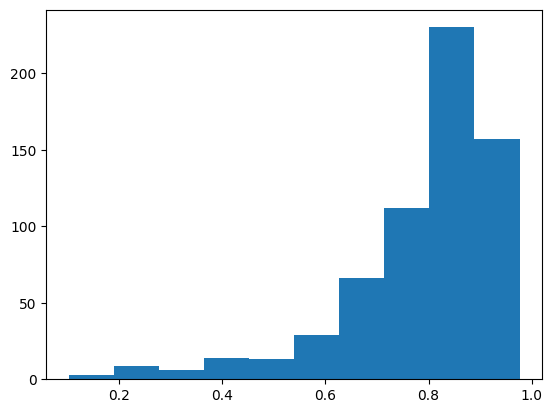

In [7]:
import matplotlib.pyplot as plt
import numpy as np
dice_scores_notime = np.array(list(users_and_dice_filt['Dice']))
plt.hist(dice_scores_notime)
print(f'{np.percentile(dice_scores_notime,0)=}')
print(f'{np.percentile(dice_scores_notime,25)=}')
print(f'{np.percentile(dice_scores_notime,50)=}')
print(f'{np.percentile(dice_scores_notime,75)=}')
print(f'{np.percentile(dice_scores_notime,100)=}')

In [8]:
def running_average(data, window=30):
    # calculate running average
    average_y = []
    for ind in range(len(data) - window + 1):
        average_y.append(np.mean(data[ind:ind+window]))
    for ind in range(window - 1):
        average_y.insert(0, np.nan)
    return average_y

def extract_model_dataframe(data, model, running_average_window=30):
    data_for_model = data[data['Model'] == model]
    data_for_model.insert(3, 'running_average', running_average(data_for_model['Dice'], window=running_average_window))
    return data_for_model

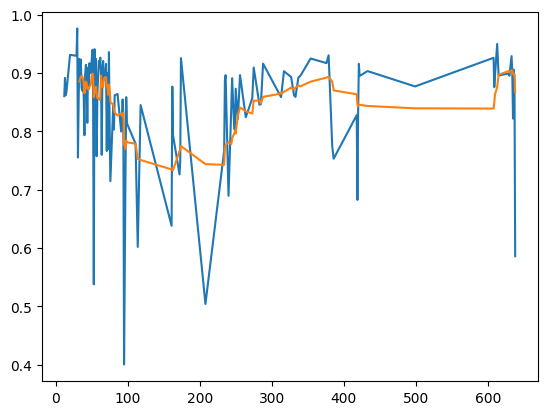

In [9]:
dice_scores_filt_thigh = extract_model_dataframe(users_and_dice_filt, 'Thigh', 10)
plt.plot(dice_scores_filt_thigh[['Dice', 'running_average']])

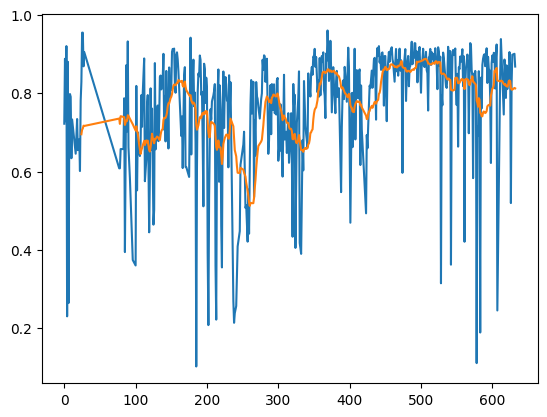

In [10]:
dice_scores_filt_leg = extract_model_dataframe(users_and_dice_filt, 'Leg', 20)
plt.plot(dice_scores_filt_leg[['Dice', 'running_average']])

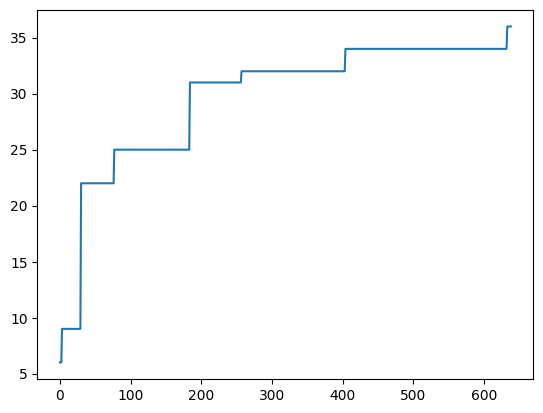

In [11]:
# Get user growth
user_numbers = list(users_and_dice_filt['User'])
max_user_list = []
max_user = 0
for user_number in user_numbers:
    if user_number > max_user:
        max_user = user_number
    max_user_list.append(max_user)

plt.plot(max_user_list)

In [12]:
def plot_dice_and_users(data_frame, user_data):
    # plot the user evolution and dice scores on the same plot
    fig, ax = plt.subplots()
    dice1, = ax.plot(data_frame['Dice'], '.', markersize=1.5, lw=0.3, color='#111111', label='DSI')
    dice2, = ax.plot(data_frame['running_average'], lw = 1.5, color='#E66100', label='DSI (moving average)')
    ax.set_ylabel('Dice Similarity Index (DSI)', color='#E66100')
    ax.set_xlabel('Model version')
    ax2 = ax.twinx()
    users, = ax2.plot(user_data, color='#5D3A9B', label='Users')
    ax2.set_ylim(0,70)
    ax2.set_ylabel('Number of users', color='#5D3A9B')
    plt.legend(handles=[dice1, dice2, users], loc='lower right')

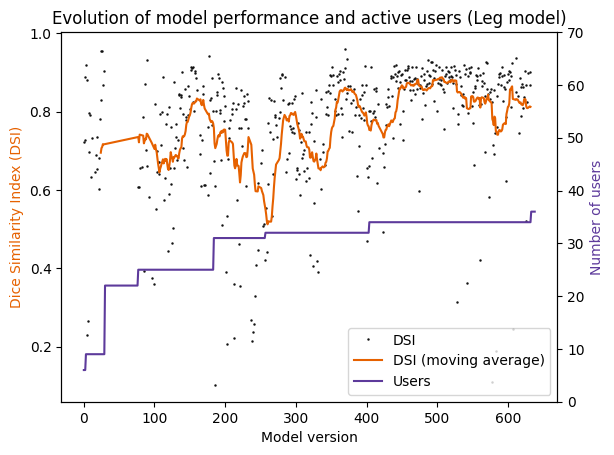

In [13]:
plot_dice_and_users(dice_scores_filt_leg, max_user_list)
plt.title('Evolution of model performance and active users (Leg model)')
plt.savefig('dice_and_users_leg.svg')

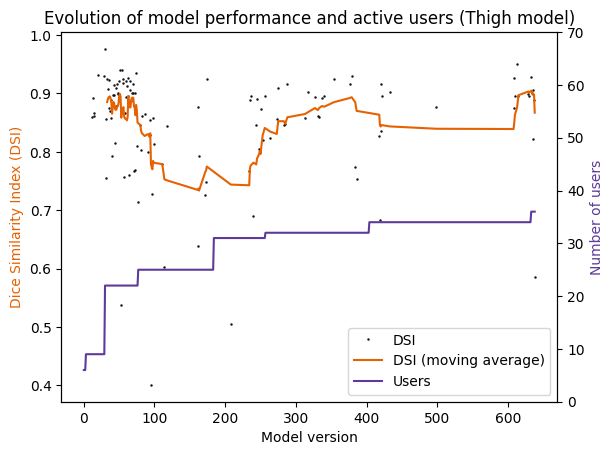

In [14]:
plot_dice_and_users(dice_scores_filt_thigh, max_user_list)
plt.title('Evolution of model performance and active users (Thigh model)')
plt.savefig('dice_and_users_thigh.svg')

# Processing the validation data

The validation data are anonymized data extracted from the local PACS. They were segmented using Dafne and manually refined.
The testing on the various model versions was made using the command (included in Dafne):
```
python /home/francesco/work/workspace/dafne/batch_validate.py --roi <roi_file.p> .
```

## Loading data

In [15]:
import os, glob, csv
import pandas as pd

#this is the model right before the validation training
training_beginning_model = 1635419523
training_end_model = 1636967897


def load_data_subdirs(base_path):
    subdirs = os.listdir(base_path)
    data_list = []
    for d in subdirs:
        current_subdir = os.path.join(base_path, d)
        txt_file_list = glob.glob(os.path.join(current_subdir, '*.txt'))
        if not txt_file_list:
            continue
        txt_file = txt_file_list[0]
        data_frame = pd.read_csv(txt_file, names=['model_id', 'dice'])
        #data_frame = data_frame.assign(name=d)
        data_frame.insert(0, 'name', d, True)
        #print(data_frame['dice'] - data_frame[data_frame['model_id'] >= training_beginning_model].iloc[0]['dice'])
        data_frame.insert(2, 'relative_dice', data_frame['dice'] - data_frame[data_frame['model_id'] >= training_beginning_model].iloc[0]['dice'])
        # add ranks of models
        data_frame.insert(3, 'model_id_rank', data_frame['model_id'].rank(method='dense'))
        data_list.append(data_frame)
    data_out = pd.concat(data_list)
    return data_out
        
                             
dice_scores_training = load_data_subdirs('validation_results/validation_training')
dice_scores_final_validation = load_data_subdirs('validation_results/final_validation')

def extract_data(data_frame):
    data_frame = data_frame[training_beginning_model <= data_frame['model_id']]
    data_frame = data_frame[data_frame['model_id'] <= training_end_model]
    data_frame['model_id_rank'] -= data_frame['model_id_rank'].min()
    return data_frame
    
dice_scores_training = extract_data(dice_scores_training)
dice_scores_final_validation = extract_data(dice_scores_final_validation)

In [16]:
print('Number of training data:',len(dice_scores_training['name'].unique()))
print('Number of valudation data:',len(dice_scores_final_validation['name'].unique()))

Number of training data: 25
Number of valudation data: 13


In [17]:
import matplotlib.pyplot as plt

def groupby_to_numpy(pd_groupby):
    data_list = []
    for name, group in pd_groupby:
        data_list.append(np.array(group))
    return np.stack(data_list).T

def plot_data(data_frame):
    relative_dice_data = data_frame.groupby('name')
    relative_dice_data.plot(x = 'model_id_rank', y = 'relative_dice', ax = plt.gca(), linewidth=0.3, color='gray')
    relative_dice_mean = data_frame.groupby('model_id').mean()
    relative_dice_mean.plot(x = 'model_id_rank', y = 'relative_dice', ax = plt.gca(), linewidth=2.5, color='#E66100')
    plt.gca().get_legend().remove()
    plt.xlabel('Model version')
    plt.ylabel('Dice Similarity Score (DSI)\ndifference from baseline')

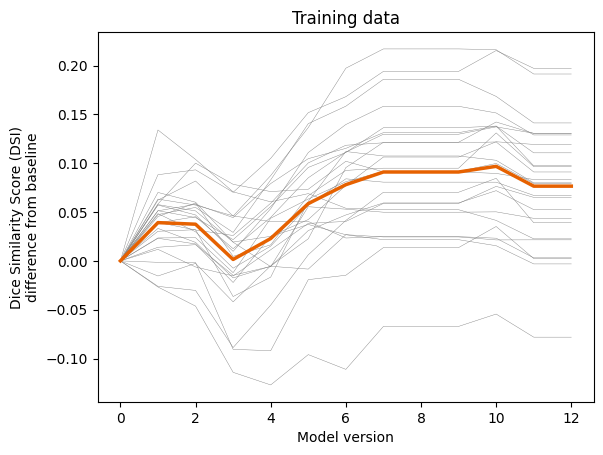

In [18]:
plot_data(dice_scores_training)
plt.title('Training data')
plt.savefig('relative_dice_training.svg')

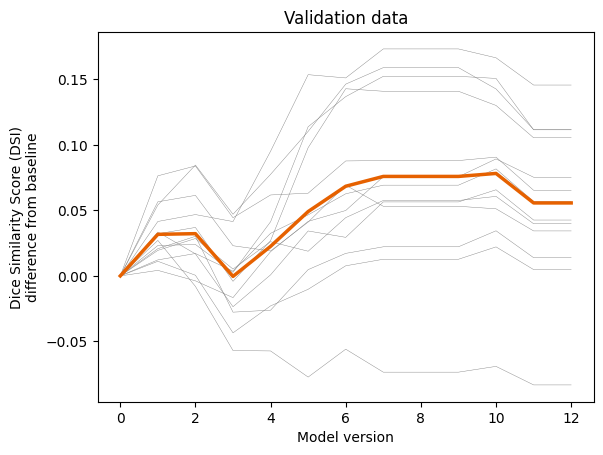

In [19]:
plot_data(dice_scores_final_validation)
plt.title('Validation data')
plt.savefig('relative_dice_validation.svg')

## Statistical evaluation
We use a linear model on the relative dice score change.

In [20]:
import statsmodels.api as sm

def fit_lm(data_frame):
    model = sm.OLS(data_frame['relative_dice'], data_frame['model_id_rank']).fit()
    return model

In [21]:
model_training = fit_lm(dice_scores_training)
model_training.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          relative_dice   R-squared (uncentered):                   0.551
Model:                            OLS   Adj. R-squared (uncentered):              0.549
Method:                 Least Squares   F-statistic:                              397.2
Date:                Mon, 16 Jan 2023   Prob (F-statistic):                    2.98e-58
Time:                        17:22:26   Log-Likelihood:                          465.38
No. Observations:                 325   AIC:                                     -928.8
Df Residuals:                     324   BIC:                                     -925.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
model_id_rank     0.0090      0.000     19.931      0.000       0.008       0.010
==============================================================================
Omnibus:                       13.745   Durbin-Watson:                   0.315
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.131
Skew:                          -0.373   Prob(JB):                     0.000191
Kurtosis:                       3.841   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
model_validation = fit_lm(dice_scores_final_validation)
model_validation.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          relative_dice   R-squared (uncentered):                   0.467
Model:                            OLS   Adj. R-squared (uncentered):              0.464
Method:                 Least Squares   F-statistic:                              147.4
Date:                Mon, 16 Jan 2023   Prob (F-statistic):                    9.32e-25
Time:                        17:22:26   Log-Likelihood:                          250.80
No. Observations:                 169   AIC:                                     -499.6
Df Residuals:                     168   BIC:                                     -496.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
model_id_rank     0.0073      0.001     12.142      0.000       0.006       0.008
==============================================================================
Omnibus:                        7.334   Durbin-Watson:                   0.270
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                8.150
Skew:                          -0.345   Prob(JB):                       0.0170
Kurtosis:                       3.825   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""